# Modelowanie akustyczne w rozpoznawaniu mowy

Na tym ćwiczeniu podamy przykład modelowania akustycznego jakie używamy w rozpoznawaniu mowy. Problem ten zostanie przedstawiony na podstawie problemu klasyfikacji fonemów na poszczególnych ramakach sygnału.

Zacznijmy od zaimportowania numy i matplotlib:

In [55]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Zaimportujmy tez następujące klasy i moduły:

In [56]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adadelta
from keras.utils import to_categorical
import pickle

Ściągniemy następujące pliki i programy:

- clarin_small.h5 - podzbiór większego korpusu mowy. Plik ten zawiera cechy MFCC zapisane w formacie HDF5
- indices_small.pkl - indeksy do podziału tego zbioru na train/valid/test w formacie pickle
- phones.txt - lista fonemów użyta w pliku HDF5 (tam dla oszczędności użyto indeksy zamiast string'i)
- data.py - program do wczytywania pliku HDF5

In [57]:
!wget https://mul.pja.edu.pl/zum/clarin_small.h5
!wget https://mul.pja.edu.pl/zum/indices_small.pkl #indeksy dla zbioru tren/test/walid
!wget https://mul.pja.edu.pl/zum/phones.txt
!wget https://mul.pja.edu.pl/zum/data.py

--2021-01-01 21:57:57--  https://mul.pja.edu.pl/zum/clarin_small.h5
Resolving mul.pja.edu.pl (mul.pja.edu.pl)... 91.230.222.111, 2001:67c:23f4::ab02
Connecting to mul.pja.edu.pl (mul.pja.edu.pl)|91.230.222.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1177015360 (1.1G)
Saving to: ‘clarin_small.h5.2’

clarin_small.h5.2   100%[===================>]   1.10G  16.2MB/s    in 86s     

2021-01-01 21:59:23 (13.1 MB/s) - ‘clarin_small.h5.2’ saved [1177015360/1177015360]

--2021-01-01 21:59:23--  https://mul.pja.edu.pl/zum/indices_small.pkl
Resolving mul.pja.edu.pl (mul.pja.edu.pl)... 91.230.222.111, 2001:67c:23f4::ab02
Connecting to mul.pja.edu.pl (mul.pja.edu.pl)|91.230.222.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3783 (3.7K)
Saving to: ‘indices_small.pkl.2’

indices_small.pkl.2 100%[===================>]   3.69K  --.-KB/s    in 0s      

2021-01-01 21:59:24 (178 MB/s) - ‘indices_small.pkl.2’ saved [3783/3783]

--2021-01-01 

Zaimportuj klasę Corpus z modułu data i wczytaj plik 'clarin_small.h5'. Konstruktor klasy Corpus wymaga nazwę pliku jako pierwszy argument. Oprócz tego, ustaw `load_normalized=True` oraz `merge_utts=False`.

Po skonstruowaniu korpusu, użyj metody `get()` żeby pobrać wsyzstkie dane. Metoda ta zwraca 2 tablice numpy: tablicę danych wejściowych i wyjściowych.

In [58]:
from data import Corpus

corpus = Corpus('clarin_small.h5', load_normalized=True, merge_utts=False) #korpus danych
corp_x, corp_y = corpus.get()

/content/data.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  inputs=np.array(inputs)
/content/data.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  outputs=np.array(outputs)


Wypisz rozmiary tych tablic:

In [59]:
print(corp_x.shape) # 1327 plików
print(corp_x[0].shape) # 1793 nagrań (ramek, jednostek czasu) 39 -cechy nfcc
print(corp_y.shape)
print(corp_y[0].shape)

(1327,)
(1263, 39)
(1327,)
(1263,)


Wypisz wartość dowolnej wypowiedzi z tego korpusu:

In [60]:
print(corp_x[0])

[[-1.25405307 -0.21839516  0.0228622  ... -0.13924277 -0.13410437
  -0.11730251]
 [-1.15010945 -0.31298118 -0.27531033 ... -0.13950512 -0.13328189
  -0.12105913]
 [-1.13852079 -0.29674099 -0.37212302 ... -0.13276725 -0.12326641
  -0.12547829]
 ...
 [-1.24101471 -0.18716601 -0.09767863 ... -0.20994459 -0.05377894
  -0.18573951]
 [-1.10382191 -0.23057738 -0.55631968 ... -0.18177921 -0.06027161
  -0.18507572]
 [-0.80986861 -0.38627062 -0.55105793 ... -0.16556728 -0.09697047
  -0.15879016]]


Wczytaj plik 'phones.txt' i stwórz mapę zamieniającą indeksy fonemów na tekst:

In [61]:
ph_map = {}

with open('phones.txt') as f:
  for line in f:
    tok = line.strip().split() # tablica 2 wymiarowa : (liczba, fonem)
    ph_map[int(tok[0])] = tok[1]

In [62]:
print(ph_map)

{0: 'I', 1: 'S', 2: 'Z', 3: 'a', 4: 'b', 5: 'd', 6: 'dZ', 7: 'dz', 8: 'dzi', 9: 'e', 10: 'en', 11: 'f', 12: 'g', 13: 'i', 14: 'j', 15: 'k', 16: 'l', 17: 'm', 18: 'n', 19: 'ni', 20: 'o', 21: 'on', 22: 'p', 23: 'r', 24: 's', 25: 'si', 26: 'sil', 27: 't', 28: 'tS', 29: 'ts', 30: 'tsi', 31: 'u', 32: 'v', 33: 'w', 34: 'x', 35: 'z', 36: 'zi'}


Wypisz fonemy dowolnej wypowiedzi w postaci tekstowej:

In [63]:
phs = []

for ph in corp_y[0]:
  phs.append(ph_map[ph])

print(phs) # sil = silence

['sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil'

Wczytaj indeksy w formacie pickle. Użyj te indeksy do podzielenia korpusu na części: `tr_x`, `tr_y`, `dev_x`, `dev_y` oraz `tst_x`, `tst_y`.

Dla każdego podzbioru, połącz wszystkie wypowiedzi w jedną długą tablicę. Dla tablic X użyj metody `vstack`, a dla Y użyj `concatenate`.

In [64]:
with open("indices_small.pkl", 'rb') as f:
  ind = pickle.load(f)

tr_x = vstack(corp_x[ind['train']]) #łączenie nagrań w jeden wielki plik
dev_x = vstack(corp_x[ind['dev']]) # walidacyjny
tst_x = vstack(corp_x[ind['test']])

tr_y = concatenate(corp_y[ind['train']])
dev_y = concatenate(corp_y[ind['dev']])
tst_y = concatenate(corp_y[ind['test']])

Wypisz rozmiary wszystkich tablic:

In [65]:
print(tr_x.shape)
print(dev_x.shape)
print(tst_x.shape)
print("---")
print(tr_y.shape)
print(dev_y.shape)
print(tst_y.shape)

(1498247, 39)
(173728, 39)
(186227, 39)
---
(1498247,)
(173728,)
(186227,)


## Zmienne globalne

Ustalmy pewne globalne zmienne przydatne do obliczeń:

- input_dim - ilość cech w jednej ramce - można wyliczyć z którejś tablicy X
- output_dim - ilość różnych fonemów - można wyliczyć z rozmiaru mapy fonemów
- hidden_num - szerokość wartswy ukrytej modelu (np 256)
- batch_size - ilość próbek w jednym batchu (nie będzie 256)
- epoch_num - ilość epok

In [66]:
input_dim = tr_x.shape[1] #tyle wejść ile mamy cech w wektorze wejściowym
output_dim = len(ph_map.keys()) #ile mamy wszystkich fonemów = wymiar wartstwy wyjściowej
hidden_num = 256 
batch_size = 100 #mniejsze niż wielkosc inputu
epoch_num = 100

Zamień tablice Y na tablicę zawierające kodowanie 'one-hot': `tr_y` przepisz do `tr_y_oh`, `dev_y` na `dev_y_oh`, a `tst_y` na `tst_y_oh`.

Do konwersji użyj metody `to_categorical`. Nie zapomnij ustawić argument `num_classes` w wywołaniu tej funkcji.

In [67]:
tr_y_oh = to_categorical(tr_y, num_classes = output_dim) # oh = one hot -> cat do listy
tst_y_oh = to_categorical(tst_y, num_classes = output_dim)
dev_y_oh = to_categorical(dev_y, num_classes = output_dim)

In [68]:
print(tr_y_oh[0]) #37 = ilość fonemów ; 0/1 z jedną 1 (onehot)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Model

Stwórz model typu `Sequential`. Dodaj do niego dwie warstwy typu `Dense`:

- pierwsza ma mieć `input_dim` równy zmiennej globalnej `input_dim`, `units` ma odpowiadać `hidden_num`, a funkcja aktywacji niech będzie `sigmoid`.
- druga ma mieć `units` równy `output_dim`, a funkcja aktywacji ma być  `softmax`

Ustaw zmienne:

- `optimizer` ustaw na `Adadelta()`
- `loss` na `categorical_crossentropy`
- `metrics` na listę: `['acc']`

In [69]:
model = Sequential()
model.add(Dense(input_dim = input_dim, units = hidden_num, activation = 'sigmoid')) #units = jak duza wartwa ukryta, wyjście
model.add(Dense(units = output_dim, activation = 'softmax'))

optimizer = Adadelta()
loss = 'categorical_crossentropy'
metrics = ['acc']

Skommpiluj model, ustawiając odpowiednio `loss`, `optimizer` i `metrics`.

Użyj metody `summary()` do wyświetlenia statystyk modelu:

In [70]:
model.compile(loss = loss, optimizer = optimizer, metrics = metrics)
print(model.summary()) 

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 256)               10240     
_________________________________________________________________
dense_20 (Dense)             (None, 37)                9509      
Total params: 19,749
Trainable params: 19,749
Non-trainable params: 0
_________________________________________________________________
None


Użyj również metody `plot_model` z `keras.utils` do zapisania rysunku z modelem do pliku. Potem użyj metody `Image` z `IPython.display` do wyświetlenia tego obrazu.

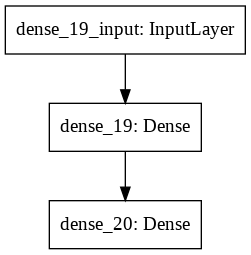

In [71]:
from keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file = 'model_seq.png')
Image(filename = 'model_seq.png')

## Trenowanie

Teraz możemy zacząć z trenowaniem. Zrób najpierw małą zmienną o nazwie `val` zawierającą parę `(x,y)` z danymi z podzbioru dev.

Uruchom metodę `fit` modelu podając odpowiednio:

- jako 2 pierwsze argumenty X i Y zbioru treningowego
- parametr `shuffle` ustaw na `True`
- parametr `batch_size` ustaw na globalną zmienną `batch_size`
- parametr `epochs` ustaw na `epoch_num`
- parametr `verbose` można ustawić na 1, żeby zobaczyć progress
- parametr `validation_data` ustaw na wyżej utworzoną parę `val`

Funkcja ta zwróci objekt który nazwijemy `hist`.

In [72]:
val = (dev_x, dev_y_oh)
epoch_num = 40
hist = model.fit(tr_x, tr_y_oh, shuffle = True, batch_size = batch_size, epochs = epoch_num, verbose = 1, validation_data = val)

Epoch 1/40
14983/14983 [==============================] - 36s 2ms/step - loss: 3.3553 - acc: 0.1716 - val_loss: 2.8847 - val_acc: 0.2941
Epoch 2/40
14983/14983 [==============================] - 36s 2ms/step - loss: 2.8797 - acc: 0.2899 - val_loss: 2.8079 - val_acc: 0.2941
Epoch 3/40
14983/14983 [==============================] - 36s 2ms/step - loss: 2.8086 - acc: 0.2894 - val_loss: 2.7393 - val_acc: 0.2941
Epoch 4/40
14983/14983 [==============================] - 36s 2ms/step - loss: 2.7426 - acc: 0.2894 - val_loss: 2.6750 - val_acc: 0.2974
Epoch 5/40
14983/14983 [==============================] - 36s 2ms/step - loss: 2.6780 - acc: 0.2946 - val_loss: 2.6141 - val_acc: 0.3120
Epoch 6/40
14983/14983 [==============================] - 36s 2ms/step - loss: 2.6183 - acc: 0.3119 - val_loss: 2.5565 - val_acc: 0.3344
Epoch 7/40
14983/14983 [==============================] - 36s 2ms/step - loss: 2.5625 - acc: 0.3350 - val_loss: 2.5020 - val_acc: 0.3552
Epoch 8/40
14983/14983 [=================

W objekcie `hist` jest składowa `history`, która jest słownikiem. Narysuj historię `'loss'` używając matplotlib:

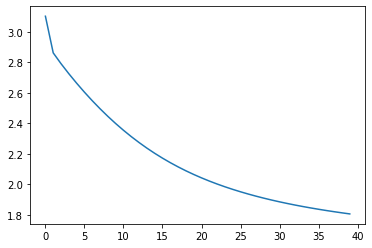

In [73]:
plot(hist.history['loss'])

## Ewaluacja

Użyj metody `evaluate` na zbiorze testowym, żeby policzyć jakość modelu.

In [74]:
res = model.evaluate(tst_x, tst_y_oh, batch_size = batch_size, verbose = 1)

1863/1863 [==============================] - 3s 2ms/step - loss: 1.7866 - acc: 0.5183


Powyższa metoda zwraca parę wartości. Pierwszy element tej pary to Loss, a drugi Accuracy. Wypisz te dwie wartości:

In [75]:
print(f'Loss: {res[0]}')
print(f'Acc: {res[1]}')

Loss: 1.7865608930587769
Acc: 0.5182760953903198


Powyższe obliczenie w bardzo łatwy sposób może policzyć jakość modelu, ale żeby zwrócić dokładnie wynik działania modelu, należy użyć metody `predict_classes`.

In [76]:
out = model.predict_classes(tst_x, batch_size = batch_size, verbose = 1)

  57/1863 [..............................] - ETA: 1s  

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1863/1863 [==============================] - 2s 909us/step


Narysuj macierz konfuzji używając wyniku rozpoznanych klas z metody powyżej.

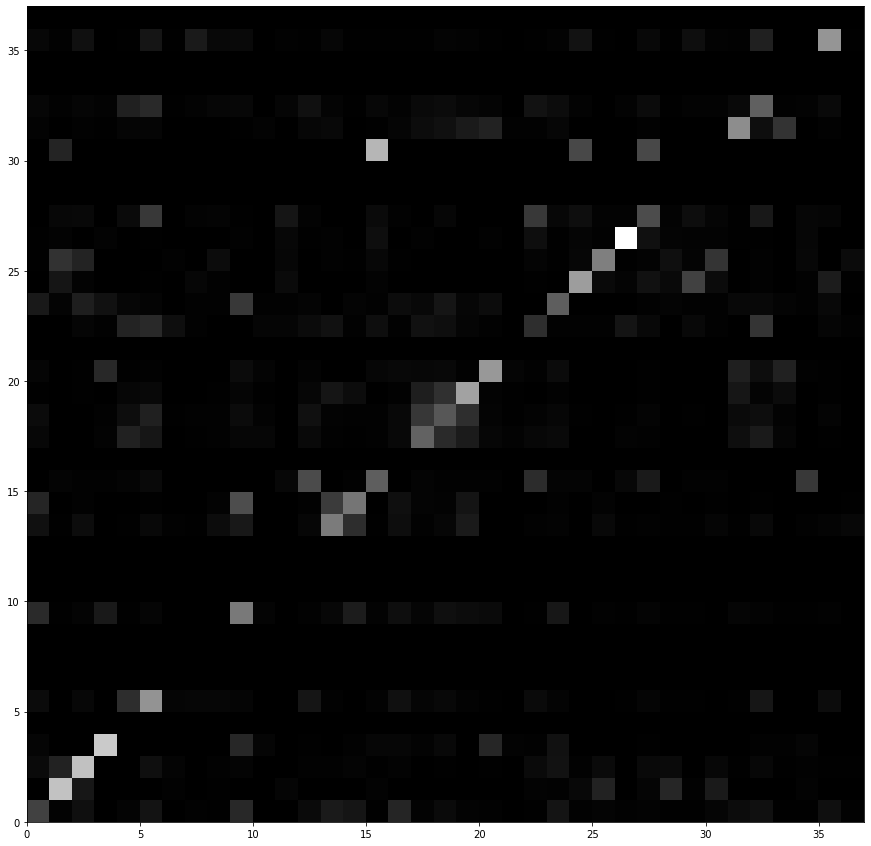

In [77]:
confusion = zeros((output_dim, output_dim))

for s in range(len(out)):
  confusion[out[s], tst_y[s]] += 1

for c in range(output_dim):
  if sum(confusion[c, :]) > 0:
    confusion[c, :] /= sum(confusion[c, :])

figure(figsize = (15, 15))
pcolormesh(confusion, cmap = cm.gray)

# Zadanie domowe

## Na ocenę 3

Przetestuj różne algorytmy optymalizacyjne (min. 3 dodatkowe). Po zapuszczeniu trenowania przez dostateczną ilość epok (np. 100) podsumuj wyniki używając poanotowanych wykresów.

## Na ocenę 4

Przetestuje różne topologie sieci (min. 3 dodatkowe) typu feed forward. Spróbuj zastosować Dropout albo nawet sieci splotowe. Podsumowanie ma zawierać zarówno opis topologii, jak i wykres porównujący proces trenowania oraz ostateczny wynik. ( dropout, sieci slotowe (konwolucyjne) ; różne kombinacje ich i gęstych  np. 1 więcej gęstych, 2 gęste dropouty, 3 gęste dropouty konwu)

## Na ocenę 5

Tak jak wyżej, porównaj sieć z zajęć do sieci o topologii rekurencyjnej (min. 2 rodzaje). -> powinny być najlepsze, ale nie musi sie to udać w 100% ; LSTM GRU


In [78]:
tr_x_ = np.expand_dims(tr_x, 2)
dev_x_ = np.expand_dims(dev_x, 2)
tst_x_ = np.expand_dims(tst_x, 2)

In [79]:
dev_x_.shape

(173728, 39, 1)

MODEL 1
- Pierwsza warstwa Long-Short Term Memory (LSTM) (50 jednostek)
- Druga warstwa Dropout z parametrem 0.2
- Ponownie warstwa LSTM
- Ponownie warstwa Dropout po warstwie LSTM (50 jednostek)
- Warstwa wyjściowa z funkcją aktywacji softmax

In [80]:
from keras import layers
from keras.layers import Dense, Activation, LSTM, Flatten, Dropout


model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (input_dim, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = output_dim, activation = 'softmax'))

optimizer = Adadelta()
loss = 'categorical_crossentropy'
metrics = ['acc']

model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

print(model.summary()) 

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 39, 50)            10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 39, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 37)                1887      
Total params: 32,487
Trainable params: 32,487
Non-trainable params: 0
_________________________________________________________________
None


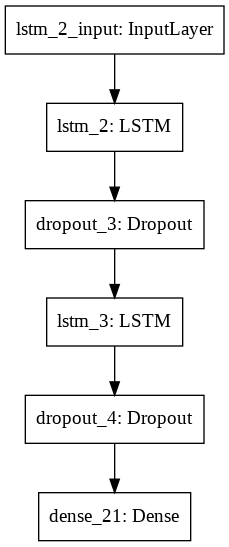

In [81]:
plot_model(model, to_file = 'model_seq.png')
Image(filename = 'model_seq.png')

In [82]:
val = (dev_x_, dev_y_oh)
epoch_num = 40
hist1 = model.fit(tr_x_, tr_y_oh, shuffle = True, batch_size = batch_size, epochs = epoch_num, verbose = 1, validation_data = val)

Epoch 1/40
14983/14983 [==============================] - 114s 7ms/step - loss: 3.4740 - acc: 0.2116 - val_loss: 2.9898 - val_acc: 0.2941
Epoch 2/40
14983/14983 [==============================] - 111s 7ms/step - loss: 2.9967 - acc: 0.2886 - val_loss: 2.8690 - val_acc: 0.2942
Epoch 3/40
14983/14983 [==============================] - 110s 7ms/step - loss: 2.8782 - acc: 0.2905 - val_loss: 2.7944 - val_acc: 0.2980
Epoch 4/40
14983/14983 [==============================] - 111s 7ms/step - loss: 2.7877 - acc: 0.2960 - val_loss: 2.6596 - val_acc: 0.3321
Epoch 5/40
14983/14983 [==============================] - 110s 7ms/step - loss: 2.6580 - acc: 0.3418 - val_loss: 2.5637 - val_acc: 0.3554
Epoch 6/40
14983/14983 [==============================] - 110s 7ms/step - loss: 2.5822 - acc: 0.3502 - val_loss: 2.5136 - val_acc: 0.3552
Epoch 7/40
14983/14983 [==============================] - 111s 7ms/step - loss: 2.5321 - acc: 0.3521 - val_loss: 2.4701 - val_acc: 0.3569
Epoch 8/40
14983/14983 [==========

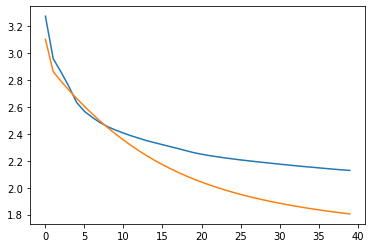

In [83]:
plot(hist1.history['loss'])
plot(hist.history['loss'])

In [84]:
res = model.evaluate(tst_x_, tst_y_oh, batch_size = batch_size, verbose = 1)
print(f'Loss: {res[0]}')
print(f'Acc: {res[1]}')

1863/1863 [==============================] - 7s 4ms/step - loss: 2.0633 - acc: 0.4329
Loss: 2.0633435249328613
Acc: 0.43285882472991943


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1863/1863 [==============================] - 6s 3ms/step


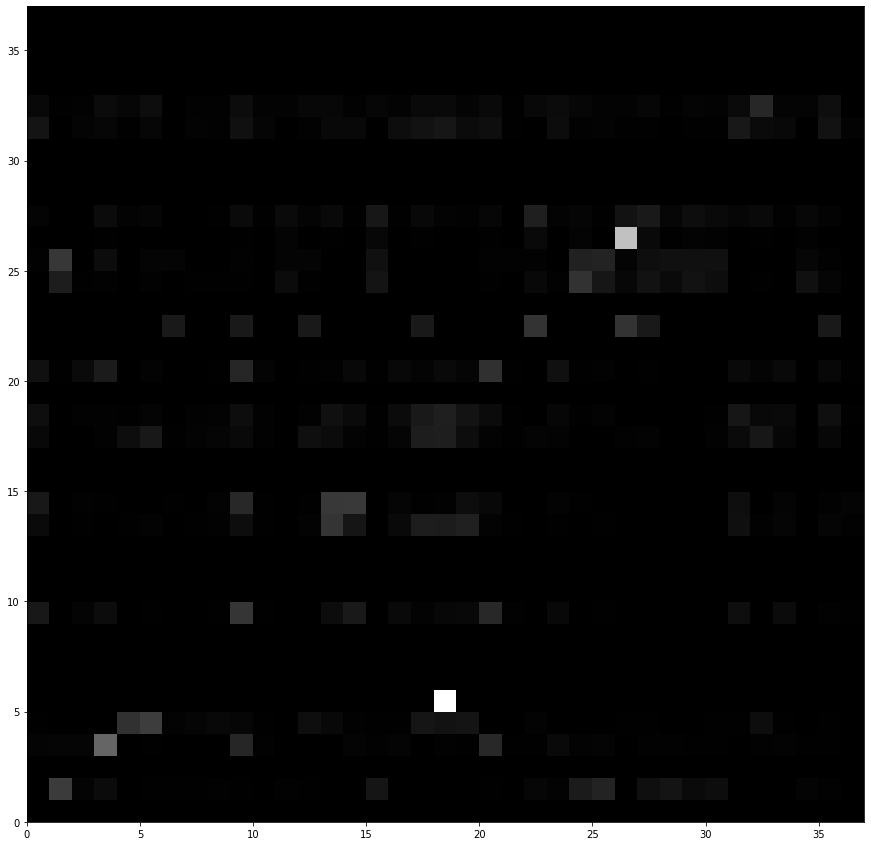

In [85]:
out = model.predict_classes(tst_x_, batch_size = batch_size, verbose = 1)
confusion = zeros((output_dim, output_dim))

for s in range(len(out)):
  confusion[out[s], tst_y[s]] += 1

for c in range(output_dim):
  if sum(confusion[c, :]) > 0:
    confusion[c, :] /= sum(confusion[c, :])

figure(figsize = (15, 15))
pcolormesh(confusion, cmap = cm.gray)

MODEL 2
- Pierwsza warstwa LSTM (50 jednostek)
- Warstwa wygładzająca (flatten)
- Warstwa Dropout z parametrem 0.3
- Warstwa gęsta z funkcją aktywacji sigmoidalną
- Warstwa wyjściowa z funkcją aktywacji softmax

In [86]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True,
               input_shape=(39, 1)))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(input_dim, activation = 'sigmoid'))
model.add(Dense(units = output_dim, activation = 'softmax'))

optimizer = Adadelta()
loss = 'categorical_crossentropy'
metrics = ['acc']

model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

print(model.summary()) 

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 39, 50)            10400     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1950)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1950)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 39)                76089     
_________________________________________________________________
dense_23 (Dense)             (None, 37)                1480      
Total params: 87,969
Trainable params: 87,969
Non-trainable params: 0
_________________________________________________________________
None


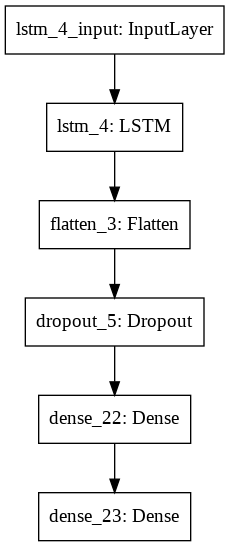

In [87]:
plot_model(model, to_file = 'model_seq.png')
Image(filename = 'model_seq.png')

In [88]:
val = (dev_x_, dev_y_oh)
epoch_num = 40
hist2 = model.fit(tr_x_, tr_y_oh, shuffle = True, batch_size = batch_size, epochs = epoch_num, verbose = 1, validation_data = val)

Epoch 1/40
14983/14983 [==============================] - 73s 5ms/step - loss: 3.7684 - acc: 0.0324 - val_loss: 3.0717 - val_acc: 0.2941
Epoch 2/40
14983/14983 [==============================] - 73s 5ms/step - loss: 3.0416 - acc: 0.2889 - val_loss: 2.9590 - val_acc: 0.2941
Epoch 3/40
14983/14983 [==============================] - 71s 5ms/step - loss: 2.9540 - acc: 0.2899 - val_loss: 2.8466 - val_acc: 0.2988
Epoch 4/40
14983/14983 [==============================] - 72s 5ms/step - loss: 2.8248 - acc: 0.3001 - val_loss: 2.7319 - val_acc: 0.3202
Epoch 5/40
14983/14983 [==============================] - 71s 5ms/step - loss: 2.7104 - acc: 0.3214 - val_loss: 2.6326 - val_acc: 0.3469
Epoch 6/40
14983/14983 [==============================] - 72s 5ms/step - loss: 2.6084 - acc: 0.3531 - val_loss: 2.5058 - val_acc: 0.3764
Epoch 7/40
14983/14983 [==============================] - 71s 5ms/step - loss: 2.4927 - acc: 0.3759 - val_loss: 2.4284 - val_acc: 0.3859
Epoch 8/40
14983/14983 [=================

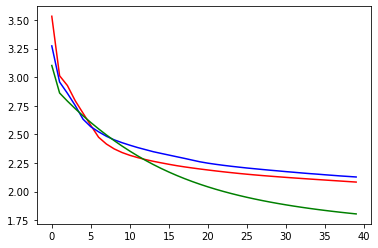

In [89]:
plot(hist2.history['loss'], color = "red")
plot(hist1.history['loss'], color = "blue")
plot(hist.history['loss'], color = "green")

In [90]:
res = model.evaluate(tst_x_, tst_y_oh, batch_size = batch_size, verbose = 1)
print(f'Loss: {res[0]}')
print(f'Acc: {res[1]}')

1863/1863 [==============================] - 6s 3ms/step - loss: 2.0535 - acc: 0.4463
Loss: 2.0534536838531494
Acc: 0.44629403948783875


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1863/1863 [==============================] - 4s 2ms/step


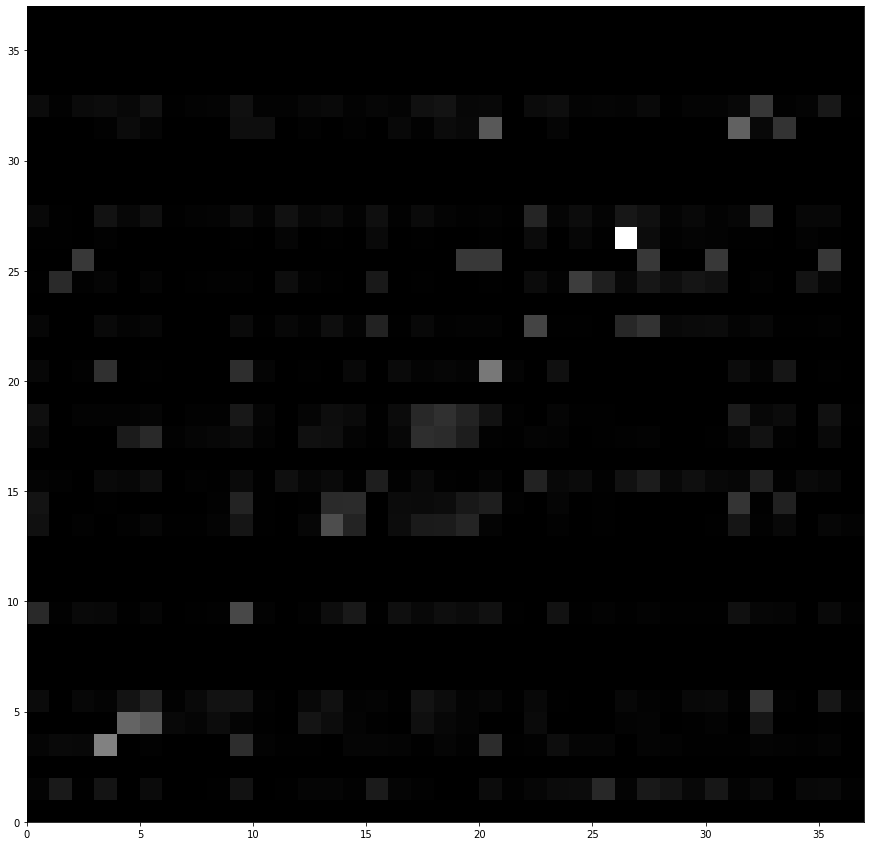

In [91]:
out = model.predict_classes(tst_x_, batch_size = batch_size, verbose = 1)
confusion = zeros((output_dim, output_dim))

for s in range(len(out)):
  confusion[out[s], tst_y[s]] += 1

for c in range(output_dim):
  if sum(confusion[c, :]) > 0:
    confusion[c, :] /= sum(confusion[c, :])

figure(figsize = (15, 15))
pcolormesh(confusion, cmap = cm.gray)

MODEL 3 (Jak MODEL 1, tylko z warstwami wygładzającymi)
- Pierwsza warstwa Long-Short Term Memory (LSTM) (50 jednostek)
- Kolejna warstwa Dropout z parametrem 0.2
- Ponownie warstwa LSTM (50 jednostek)
- Warstwa wygładzająca
- Warstwa Dropout po warstwie LSTM (parametr 0.2)
- Warstwa wyjściowa z funkcją aktywacji softmax

In [92]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (input_dim, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(units = output_dim, activation = 'softmax'))

optimizer = Adadelta()
loss = 'categorical_crossentropy'
metrics = ['acc']

model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

print(model.summary()) 

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 39, 50)            10400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 39, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
flatten_4 (Flatten)          (None, 50)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 37)                1887      
Total params: 32,487
Trainable params: 32,487
Non-trainable params: 0
_________________________________________________

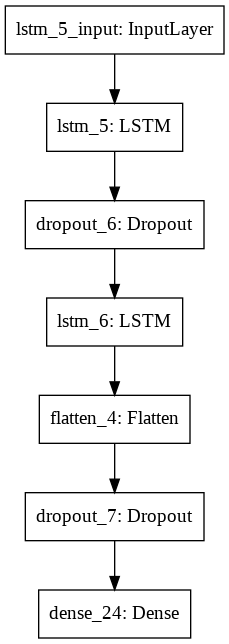

In [93]:
plot_model(model, to_file = 'model_seq.png')
Image(filename = 'model_seq.png')

In [94]:
val = (dev_x_, dev_y_oh)
epoch_num = 40
hist3 = model.fit(tr_x_, tr_y_oh, shuffle = True, batch_size = batch_size, epochs = epoch_num, verbose = 1, validation_data = val)

Epoch 1/40
14983/14983 [==============================] - 112s 7ms/step - loss: 3.5018 - acc: 0.2246 - val_loss: 3.0086 - val_acc: 0.2941
Epoch 2/40
14983/14983 [==============================] - 109s 7ms/step - loss: 2.9959 - acc: 0.2891 - val_loss: 2.8246 - val_acc: 0.2956
Epoch 3/40
14983/14983 [==============================] - 110s 7ms/step - loss: 2.7966 - acc: 0.2973 - val_loss: 2.6177 - val_acc: 0.3487
Epoch 4/40
14983/14983 [==============================] - 109s 7ms/step - loss: 2.6211 - acc: 0.3454 - val_loss: 2.5397 - val_acc: 0.3555
Epoch 5/40
14983/14983 [==============================] - 109s 7ms/step - loss: 2.5571 - acc: 0.3493 - val_loss: 2.4955 - val_acc: 0.3579
Epoch 6/40
14983/14983 [==============================] - 110s 7ms/step - loss: 2.5203 - acc: 0.3498 - val_loss: 2.4638 - val_acc: 0.3607
Epoch 7/40
14983/14983 [==============================] - 109s 7ms/step - loss: 2.4906 - acc: 0.3523 - val_loss: 2.4381 - val_acc: 0.3621
Epoch 8/40
14983/14983 [==========

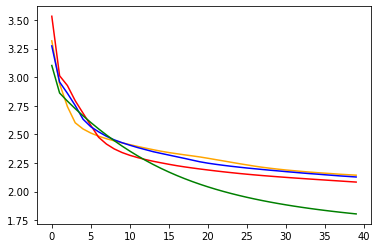

In [95]:
plot(hist3.history['loss'], color = "orange")
plot(hist2.history['loss'], color = "red")
plot(hist1.history['loss'], color = "blue")
plot(hist.history['loss'], color = "green")

In [96]:
res = model.evaluate(tst_x_, tst_y_oh, batch_size = batch_size, verbose = 1)
print(f'Loss: {res[0]}')
print(f'Acc: {res[1]}')

1863/1863 [==============================] - 7s 4ms/step - loss: 2.0717 - acc: 0.4337
Loss: 2.07171630859375
Acc: 0.4336857795715332


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1863/1863 [==============================] - 6s 3ms/step


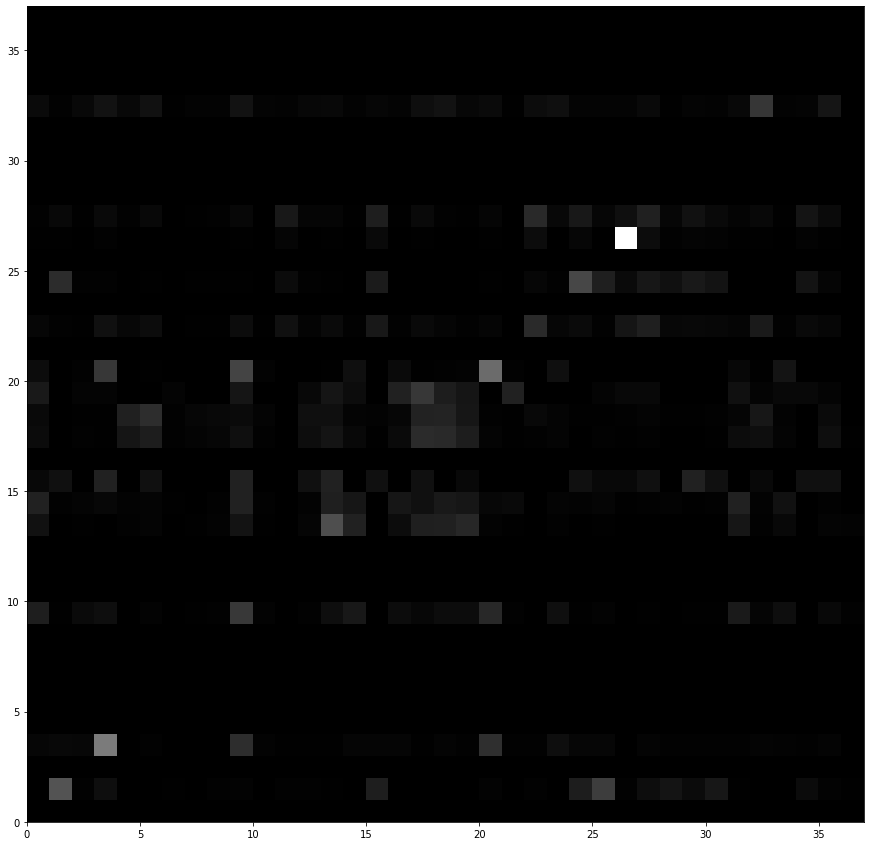

In [97]:
out = model.predict_classes(tst_x_, batch_size = batch_size, verbose = 1)
confusion = zeros((output_dim, output_dim))

for s in range(len(out)):
  confusion[out[s], tst_y[s]] += 1

for c in range(output_dim):
  if sum(confusion[c, :]) > 0:
    confusion[c, :] /= sum(confusion[c, :])

figure(figsize = (15, 15))
pcolormesh(confusion, cmap = cm.gray)

MODEL 4
- Pierwsza warstwa LSTM (100 jednostek)
- Warstwa wygładzająca (flatten)
- Warstwa Dropout z parametrem 0.3
- Warstwa gęsta z funkcją aktywacji sigmoidalną
- Warstwa wyjściowa z funkcją aktywacji softmax

In [98]:
model = Sequential()
model.add(LSTM(units = 100, return_sequences = True,
               input_shape=(39, 1)))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(input_dim, activation = 'sigmoid'))
model.add(Dense(units = output_dim, activation = 'softmax'))

optimizer = Adadelta()
loss = 'categorical_crossentropy'
metrics = ['acc']

model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

print(model.summary()) 

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 39, 100)           40800     
_________________________________________________________________
flatten_5 (Flatten)          (None, 3900)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 3900)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 39)                152139    
_________________________________________________________________
dense_26 (Dense)             (None, 37)                1480      
Total params: 194,419
Trainable params: 194,419
Non-trainable params: 0
_________________________________________________________________
None


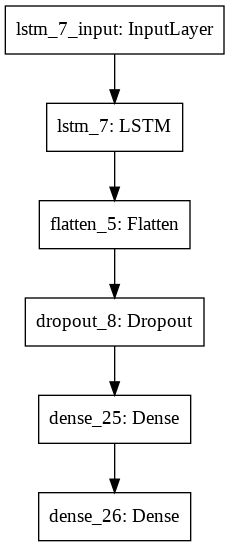

In [99]:
plot_model(model, to_file = 'model_seq.png')
Image(filename = 'model_seq.png')

In [100]:
val = (dev_x_, dev_y_oh)
epoch_num = 40
hist4 = model.fit(tr_x_, tr_y_oh, shuffle = True, batch_size = batch_size, epochs = epoch_num, verbose = 1, validation_data = val)

Epoch 1/40
14983/14983 [==============================] - 73s 5ms/step - loss: 3.5065 - acc: 0.0799 - val_loss: 2.9756 - val_acc: 0.2941
Epoch 2/40
14983/14983 [==============================] - 71s 5ms/step - loss: 2.9704 - acc: 0.2888 - val_loss: 2.8302 - val_acc: 0.2958
Epoch 3/40
14983/14983 [==============================] - 71s 5ms/step - loss: 2.8029 - acc: 0.2994 - val_loss: 2.7032 - val_acc: 0.3247
Epoch 4/40
14983/14983 [==============================] - 72s 5ms/step - loss: 2.6893 - acc: 0.3274 - val_loss: 2.6215 - val_acc: 0.3445
Epoch 5/40
14983/14983 [==============================] - 71s 5ms/step - loss: 2.6049 - acc: 0.3486 - val_loss: 2.5142 - val_acc: 0.3641
Epoch 6/40
14983/14983 [==============================] - 71s 5ms/step - loss: 2.4889 - acc: 0.3707 - val_loss: 2.3940 - val_acc: 0.3831
Epoch 7/40
14983/14983 [==============================] - 71s 5ms/step - loss: 2.3889 - acc: 0.3840 - val_loss: 2.3321 - val_acc: 0.3893
Epoch 8/40
14983/14983 [=================

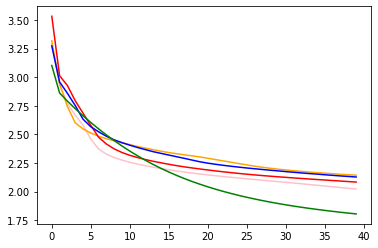

In [101]:
plot(hist4.history['loss'], color = "pink")
plot(hist3.history['loss'], color = "orange")
plot(hist2.history['loss'], color = "red")
plot(hist1.history['loss'], color = "blue")
plot(hist.history['loss'], color = "green")

In [102]:
res = model.evaluate(tst_x_, tst_y_oh, batch_size = batch_size, verbose = 1)
print(f'Loss: {res[0]}')
print(f'Acc: {res[1]}')

1863/1863 [==============================] - 6s 3ms/step - loss: 1.9928 - acc: 0.4598
Loss: 1.9927656650543213
Acc: 0.4598044455051422


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1863/1863 [==============================] - 4s 2ms/step


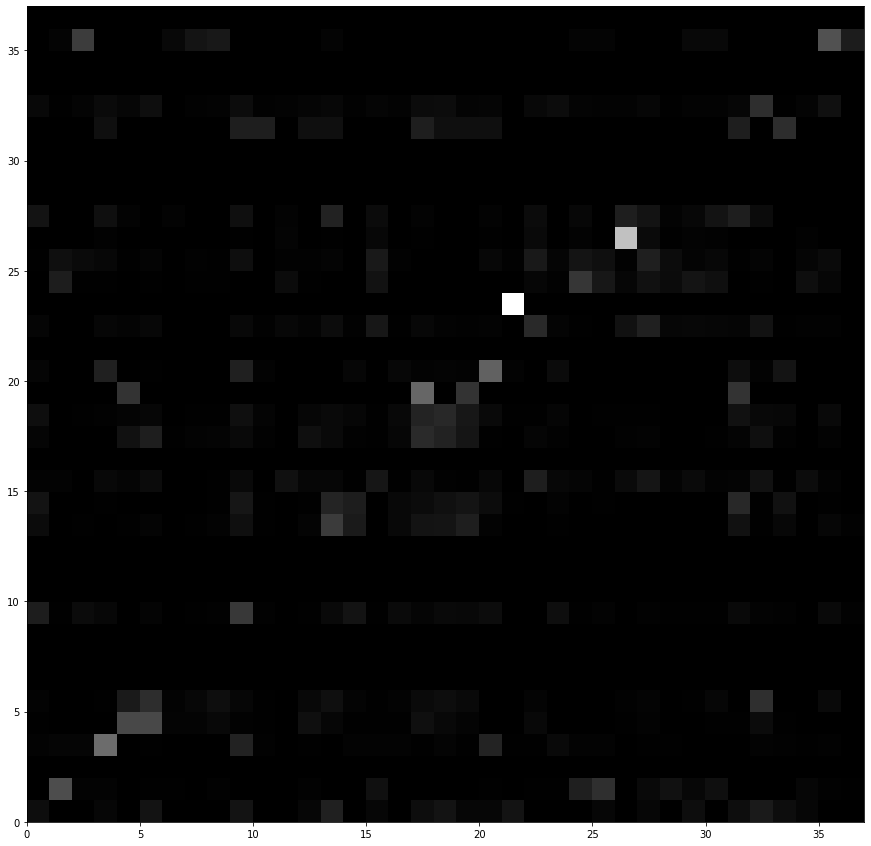

In [103]:
out = model.predict_classes(tst_x_, batch_size = batch_size, verbose = 1)
confusion = zeros((output_dim, output_dim))

for s in range(len(out)):
  confusion[out[s], tst_y[s]] += 1

for c in range(output_dim):
  if sum(confusion[c, :]) > 0:
    confusion[c, :] /= sum(confusion[c, :])

figure(figsize = (15, 15))
pcolormesh(confusion, cmap = cm.gray)

MODEL 5
- Pierwsza warstwa konwolucyjna 1 wymiarowa z 64 wyjściami z funkcją akywacji relu
- Warstwa gęsta z 16 wyjściami
- Warstwa MaxPooling
- Warstwa wygładzająca
- Wyjściowa warstwa gęsta z funkcją aktywacji softmax

In [104]:
from keras.layers import Conv1D, MaxPooling1D

model = Sequential()
model.add(Conv1D(64, 2, activation="relu", input_shape=(39,1)))
model.add(Dense(16, activation="relu"))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(units = output_dim, activation = 'softmax'))

optimizer = Adadelta()
loss = 'categorical_crossentropy'
metrics = ['acc']

model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

print(model.summary()) 

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 38, 64)            192       
_________________________________________________________________
dense_27 (Dense)             (None, 38, 16)            1040      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 19, 16)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 304)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 37)                11285     
Total params: 12,517
Trainable params: 12,517
Non-trainable params: 0
_________________________________________________________________
None


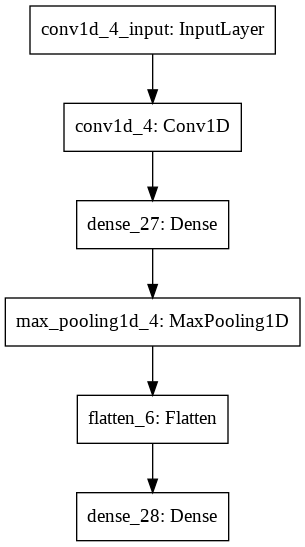

In [105]:
plot_model(model, to_file = 'model_seq.png')
Image(filename = 'model_seq.png')

In [106]:
val = (dev_x_, dev_y_oh)
epoch_num = 40
hist5 = model.fit(tr_x_, tr_y_oh, shuffle = True, batch_size = batch_size, epochs = epoch_num, verbose = 1, validation_data = val)

Epoch 1/40
14983/14983 [==============================] - 47s 3ms/step - loss: 3.4942 - acc: 0.1101 - val_loss: 2.9912 - val_acc: 0.2941
Epoch 2/40
14983/14983 [==============================] - 47s 3ms/step - loss: 2.9710 - acc: 0.2894 - val_loss: 2.8689 - val_acc: 0.2941
Epoch 3/40
14983/14983 [==============================] - 46s 3ms/step - loss: 2.8580 - acc: 0.2898 - val_loss: 2.7614 - val_acc: 0.2950
Epoch 4/40
14983/14983 [==============================] - 47s 3ms/step - loss: 2.7497 - acc: 0.2929 - val_loss: 2.6464 - val_acc: 0.3147
Epoch 5/40
14983/14983 [==============================] - 47s 3ms/step - loss: 2.6369 - acc: 0.3158 - val_loss: 2.5307 - val_acc: 0.3512
Epoch 6/40
14983/14983 [==============================] - 46s 3ms/step - loss: 2.5208 - acc: 0.3534 - val_loss: 2.4217 - val_acc: 0.3851
Epoch 7/40
14983/14983 [==============================] - 47s 3ms/step - loss: 2.4131 - acc: 0.3877 - val_loss: 2.3228 - val_acc: 0.4095
Epoch 8/40
14983/14983 [=================

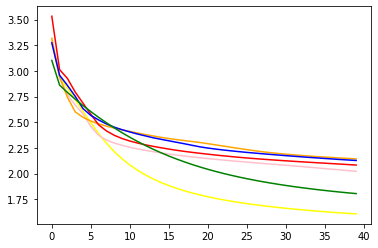

In [107]:
plot(hist5.history['loss'], color = "yellow")
plot(hist4.history['loss'], color = "pink")
plot(hist3.history['loss'], color = "orange")
plot(hist2.history['loss'], color = "red")
plot(hist1.history['loss'], color = "blue")
plot(hist.history['loss'], color = "green")

In [108]:
res = model.evaluate(tst_x_, tst_y_oh, batch_size = batch_size, verbose = 1)
print(f'Loss: {res[0]}')
print(f'Acc: {res[1]}')

1863/1863 [==============================] - 4s 2ms/step - loss: 1.5899 - acc: 0.5598
Loss: 1.5899075269699097
Acc: 0.5598167777061462


  68/1863 [>.............................] - ETA: 2s

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1863/1863 [==============================] - 3s 1ms/step


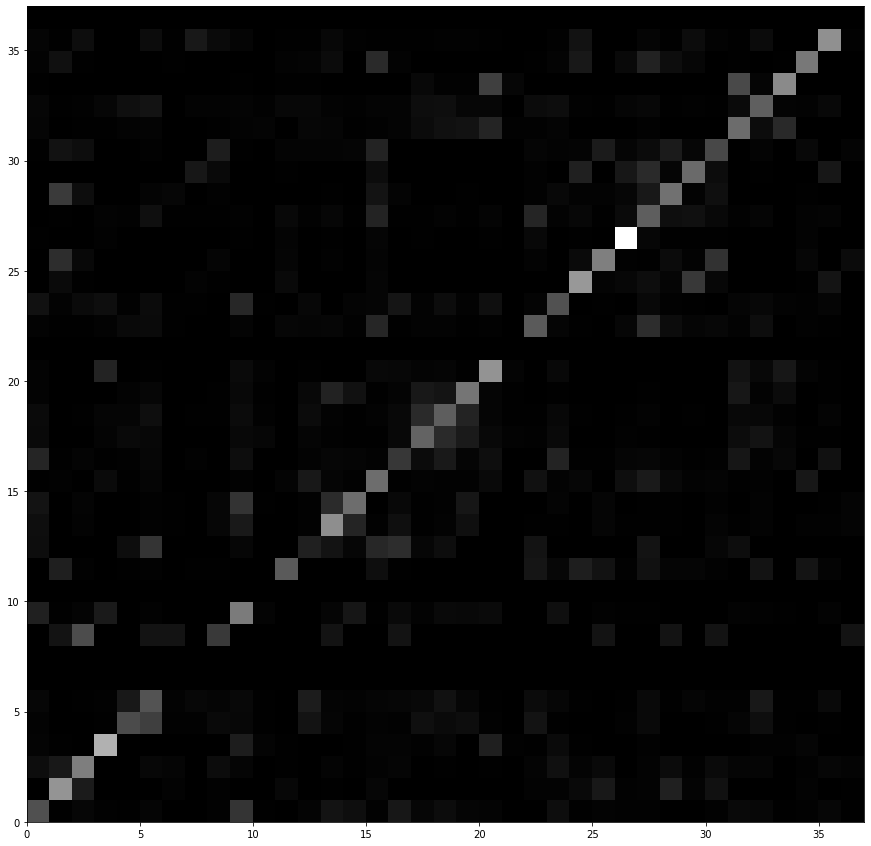

In [109]:
out = model.predict_classes(tst_x_, batch_size = batch_size, verbose = 1)
confusion = zeros((output_dim, output_dim))

for s in range(len(out)):
  confusion[out[s], tst_y[s]] += 1

for c in range(output_dim):
  if sum(confusion[c, :]) > 0:
    confusion[c, :] /= sum(confusion[c, :])

figure(figsize = (15, 15))
pcolormesh(confusion, cmap = cm.gray)

MODEL 6
- Pierwsza warstwa konwolucyjna 1 wymiarowa z 64 wyjściami z funkcją akywacji relu
- Warstwa gęsta z 16 wyjściami
- Warstwa MaxPooling
- Warstwa wygładzająca
- Warstwa dropout (0.2)
- Wyjściowa warstwa gęsta z funkcją aktywacji softmax

In [110]:
model = Sequential()
model.add(Conv1D(64, 2, activation="relu", input_shape=(39,1)))
model.add(Dense(16, activation="relu"))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(units = output_dim, activation = 'softmax'))

optimizer = Adadelta()
loss = 'categorical_crossentropy'
metrics = ['acc']

model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

print(model.summary()) 

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 38, 64)            192       
_________________________________________________________________
dense_29 (Dense)             (None, 38, 16)            1040      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 19, 16)            0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 304)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 304)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 37)                11285     
Total params: 12,517
Trainable params: 12,517
Non-trainable params: 0
_________________________________________________

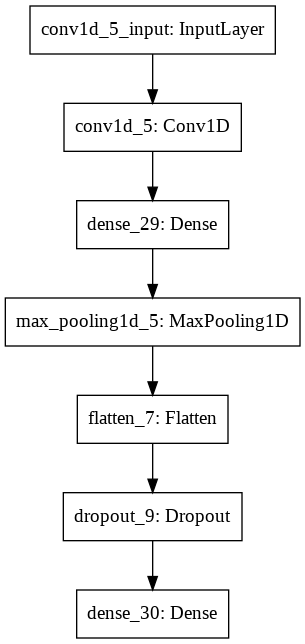

In [111]:
plot_model(model, to_file = 'model_seq.png')
Image(filename = 'model_seq.png')

In [112]:
val = (dev_x_, dev_y_oh)
epoch_num = 40
hist6 = model.fit(tr_x_, tr_y_oh, shuffle = True, batch_size = batch_size, epochs = epoch_num, verbose = 1, validation_data = val)

Epoch 1/40
14983/14983 [==============================] - 47s 3ms/step - loss: 3.4955 - acc: 0.1260 - val_loss: 3.0568 - val_acc: 0.2941
Epoch 2/40
14983/14983 [==============================] - 47s 3ms/step - loss: 3.0350 - acc: 0.2901 - val_loss: 2.9334 - val_acc: 0.2941
Epoch 3/40
14983/14983 [==============================] - 47s 3ms/step - loss: 2.9407 - acc: 0.2893 - val_loss: 2.8523 - val_acc: 0.2941
Epoch 4/40
14983/14983 [==============================] - 48s 3ms/step - loss: 2.8633 - acc: 0.2896 - val_loss: 2.7652 - val_acc: 0.2945
Epoch 5/40
14983/14983 [==============================] - 47s 3ms/step - loss: 2.7789 - acc: 0.2951 - val_loss: 2.6678 - val_acc: 0.3051
Epoch 6/40
14983/14983 [==============================] - 47s 3ms/step - loss: 2.6873 - acc: 0.3136 - val_loss: 2.5663 - val_acc: 0.3369
Epoch 7/40
14983/14983 [==============================] - 47s 3ms/step - loss: 2.5984 - acc: 0.3398 - val_loss: 2.4693 - val_acc: 0.3714
Epoch 8/40
14983/14983 [=================

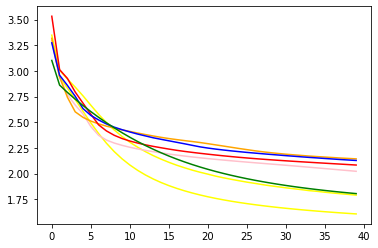

In [113]:
plot(hist6.history['loss'], color = "yellow")
plot(hist5.history['loss'], color = "yellow")
plot(hist4.history['loss'], color = "pink")
plot(hist3.history['loss'], color = "orange")
plot(hist2.history['loss'], color = "red")
plot(hist1.history['loss'], color = "blue")
plot(hist.history['loss'], color = "green")

In [114]:
res = model.evaluate(tst_x_, tst_y_oh, batch_size = batch_size, verbose = 1)
print(f'Loss: {res[0]}')
print(f'Acc: {res[1]}')

1863/1863 [==============================] - 4s 2ms/step - loss: 1.6394 - acc: 0.5477
Loss: 1.6394373178482056
Acc: 0.5477454662322998


  34/1863 [..............................] - ETA: 2s  

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1863/1863 [==============================] - 3s 1ms/step


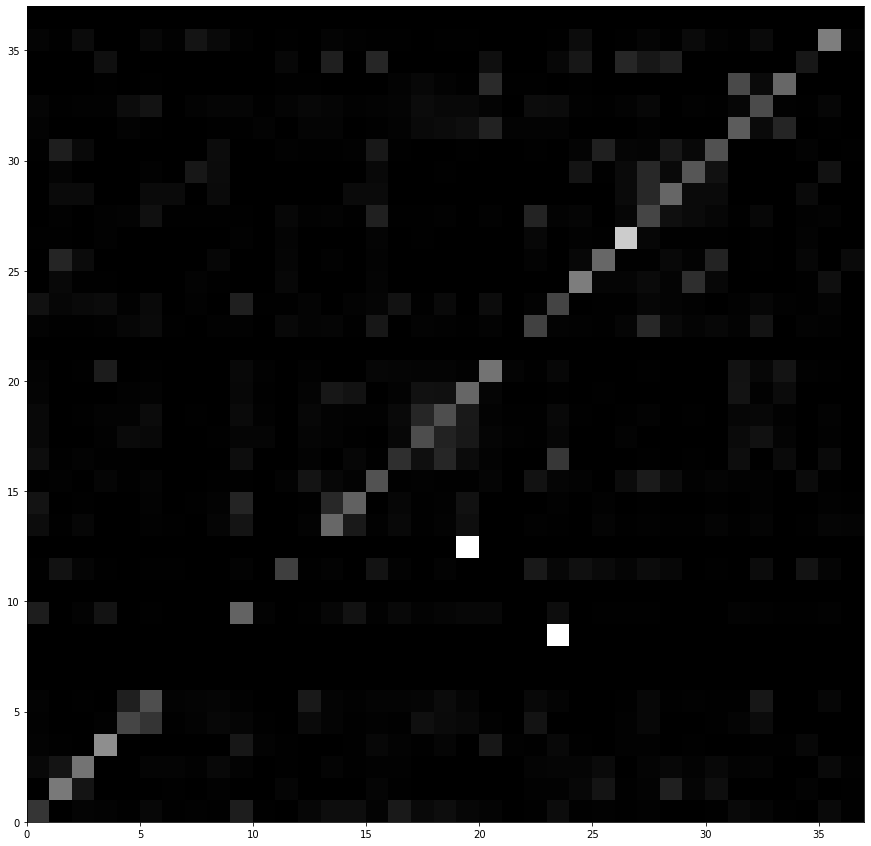

In [115]:
out = model.predict_classes(tst_x_, batch_size = batch_size, verbose = 1)
confusion = zeros((output_dim, output_dim))

for s in range(len(out)):
  confusion[out[s], tst_y[s]] += 1

for c in range(output_dim):
  if sum(confusion[c, :]) > 0:
    confusion[c, :] /= sum(confusion[c, :])

figure(figsize = (15, 15))
pcolormesh(confusion, cmap = cm.gray)

MODEL 7
- Warstwa gęsta z 256 wyjściami
- Warstwa gęsta z 128 wyjściami
- Warstwa gęsta z 64 wyjściami
- Wyjściowa warstwa gęsta z funkcją aktywacji softmax

In [116]:
model = Sequential()
model.add(Dense(input_dim = input_dim, units = 256, activation = 'sigmoid')) 
model.add(Dense(input_dim = 256, units = 128, activation = 'sigmoid')) 
model.add(Dense(input_dim = 128, units = 64, activation = 'sigmoid')) 
model.add(Dense(units = output_dim, activation = 'softmax'))

optimizer = Adadelta()
loss = 'categorical_crossentropy'
metrics = ['acc']

model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

print(model.summary()) 

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 256)               10240     
_________________________________________________________________
dense_32 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_33 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_34 (Dense)             (None, 37)                2405      
Total params: 53,797
Trainable params: 53,797
Non-trainable params: 0
_________________________________________________________________
None


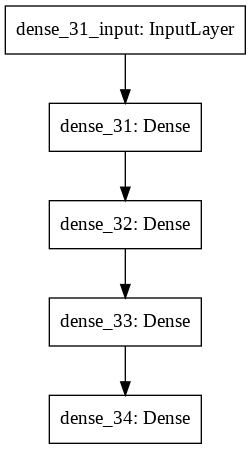

In [117]:
plot_model(model, to_file = 'model_seq.png')
Image(filename = 'model_seq.png')

In [118]:
val = (dev_x, dev_y_oh)
epoch_num = 40
hist7 = model.fit(tr_x, tr_y_oh, shuffle = True, batch_size = batch_size, epochs = epoch_num, verbose = 1, validation_data = val)

Epoch 1/40
14983/14983 [==============================] - 38s 3ms/step - loss: 3.5675 - acc: 0.1212 - val_loss: 3.0050 - val_acc: 0.2941
Epoch 2/40
14983/14983 [==============================] - 37s 2ms/step - loss: 2.9978 - acc: 0.2896 - val_loss: 2.9501 - val_acc: 0.2941
Epoch 3/40
14983/14983 [==============================] - 38s 3ms/step - loss: 2.9658 - acc: 0.2885 - val_loss: 2.9410 - val_acc: 0.2941
Epoch 4/40
14983/14983 [==============================] - 39s 3ms/step - loss: 2.9576 - acc: 0.2890 - val_loss: 2.9374 - val_acc: 0.2941
Epoch 5/40
14983/14983 [==============================] - 38s 3ms/step - loss: 2.9539 - acc: 0.2894 - val_loss: 2.9346 - val_acc: 0.2941
Epoch 6/40
14983/14983 [==============================] - 37s 2ms/step - loss: 2.9497 - acc: 0.2895 - val_loss: 2.9315 - val_acc: 0.2941
Epoch 7/40
14983/14983 [==============================] - 38s 3ms/step - loss: 2.9486 - acc: 0.2895 - val_loss: 2.9276 - val_acc: 0.2941
Epoch 8/40
14983/14983 [=================

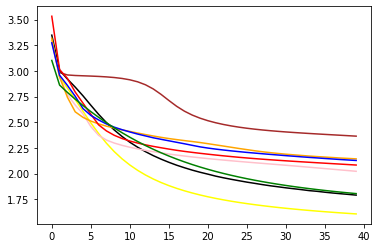

In [119]:
plot(hist7.history['loss'], color = "brown")
plot(hist6.history['loss'], color = "black")
plot(hist5.history['loss'], color = "yellow")
plot(hist4.history['loss'], color = "pink")
plot(hist3.history['loss'], color = "orange")
plot(hist2.history['loss'], color = "red")
plot(hist1.history['loss'], color = "blue")
plot(hist.history['loss'], color = "green")

In [120]:
res = model.evaluate(tst_x, tst_y_oh, batch_size = batch_size, verbose = 1)
print(f'Loss: {res[0]}')
print(f'Acc: {res[1]}')

1863/1863 [==============================] - 4s 2ms/step - loss: 2.3332 - acc: 0.3880
Loss: 2.3331573009490967
Acc: 0.3880210816860199


 113/1863 [>.............................] - ETA: 1s

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


1863/1863 [==============================] - 2s 928us/step


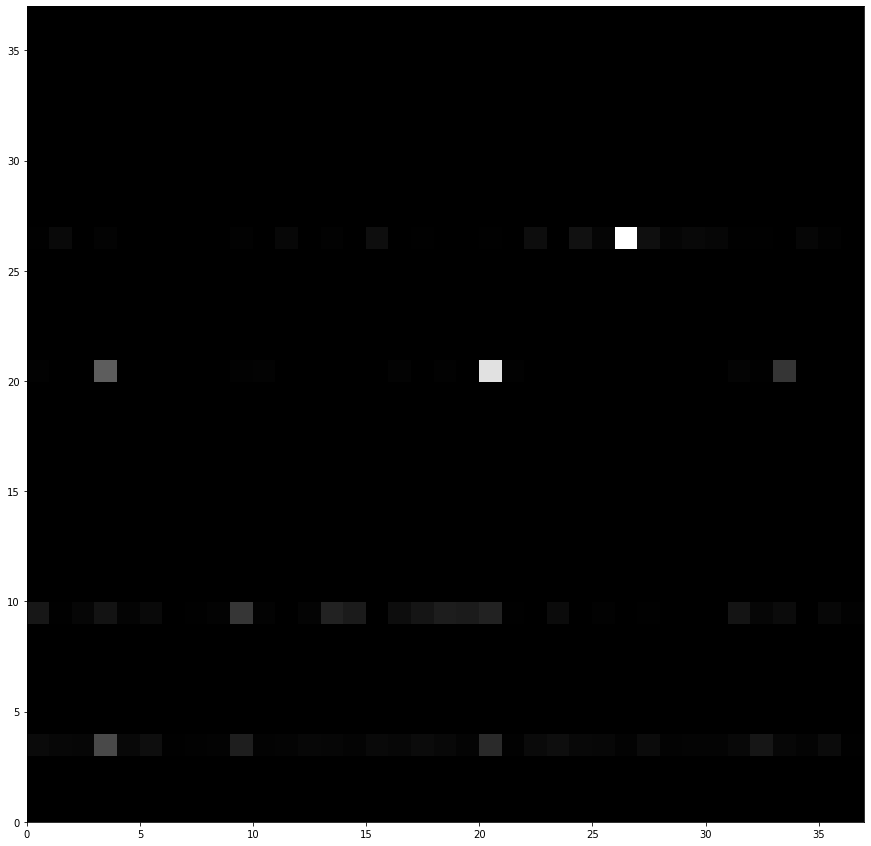

In [121]:
out = model.predict_classes(tst_x, batch_size = batch_size, verbose = 1)
confusion = zeros((output_dim, output_dim))

for s in range(len(out)):
  confusion[out[s], tst_y[s]] += 1

for c in range(output_dim):
  if sum(confusion[c, :]) > 0:
    confusion[c, :] /= sum(confusion[c, :])

figure(figsize = (15, 15))
pcolormesh(confusion, cmap = cm.gray)

Najlepszy okazał się model zawierający warstywy konwolucyjne bez warstwy dropout ( MODEL 5 )